<h1><center> SAM inference on our dataset

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import rasterio
import os

In [2]:
checkpoint_path = 'checkpoint/sam_vit_h_4b8939.pth'
sat_dir = 'part1/9'
path = 'sentinel12_s2_9_img.tif'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# load sam
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [3]:
print(os.path.exists(os.path.join(sat_dir, path)))

True


# Preprocess data

In [108]:
def read_rasterio(fp):
    img = rasterio.open(fp)
    return img
    
def read_tif_image(tif_path):
    img = Image.open(tif_path)
    img = np.array(img)
    return img

In [109]:
img = read_rasterio(os.path.join(sat_dir, path))

In [110]:
print(type(img))
img_array = img.read()
print(img_array.shape)  
rgb_channel = img_array[0:3, :, :]
rgb_channel = np.moveaxis(rgb_channel, 0, -1)
rgb_channel = cv2.resize(rgb_channel, (1000, 1000))

<class 'rasterio.io.DatasetReader'>
(6, 10980, 10980)


In [111]:
rgb_channel.max()

3847

In [112]:
# plot img
min_val = rgb_channel.min()
max_val = rgb_channel.max()

# Mettre à l'échelle l'image
scaled_image = (rgb_channel - min_val) / (max_val - min_val)  # normaliser entre 0 et 1
scaled_image = (scaled_image * 255).astype(np.uint8)

rgb_channel = scaled_image

In [113]:
rgb_plot = rgb_channel

In [114]:
rgb_channel = rgb_channel.astype(np.float32)

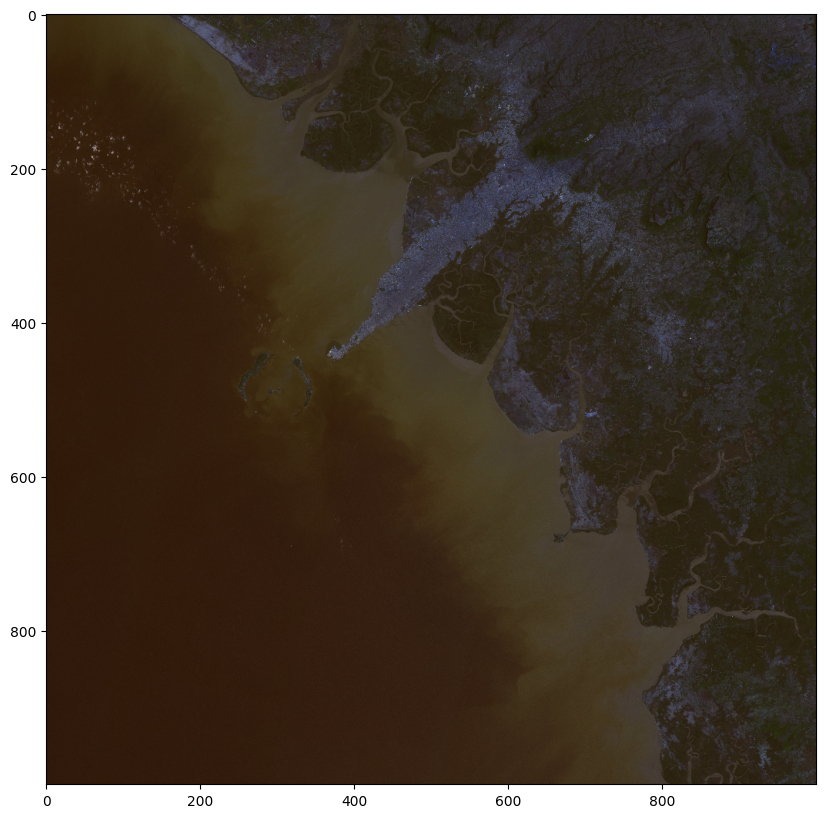

In [115]:
plt.figure(figsize=(10,10))
plt.imshow(rgb_plot)
plt.axis('on')
plt.show()

# Mask generator

In [116]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [117]:
masks = mask_generator.generate(rgb_channel)

In [118]:
print(len(masks))
print(masks[0])

12
{'segmentation': array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]]), 'area': 566813, 'bbox': [0, 0, 845, 999], 'predicted_iou': 1.0123212337493896, 'point_coords': [[296.875, 140.625]], 'stability_score': 0.9868073463439941, 'crop_box': [0, 0, 1000, 1000]}


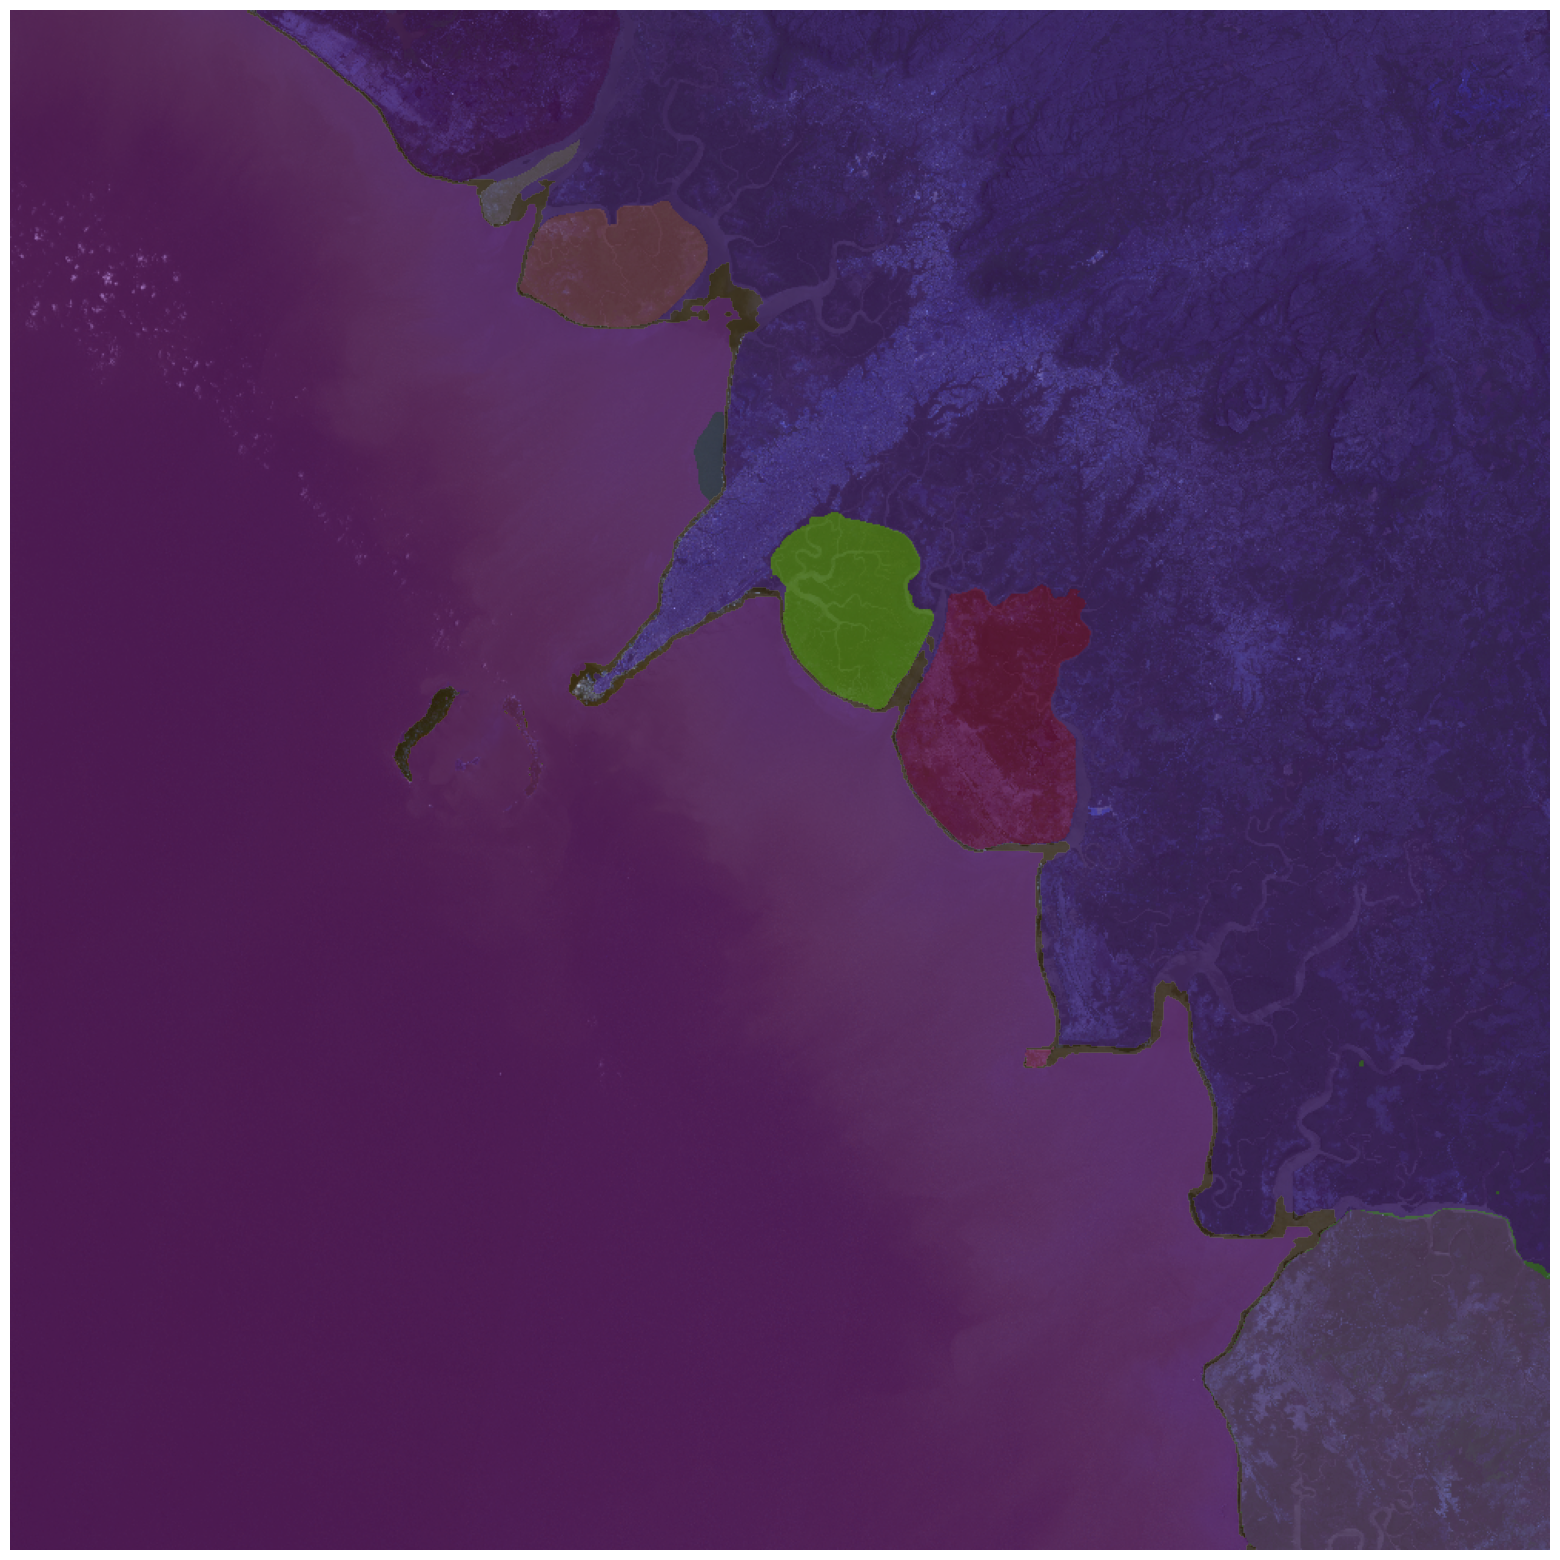

In [119]:
plt.figure(figsize=(20,20))
plt.imshow(rgb_plot)
show_anns(masks)
plt.axis('off')
plt.show() 

# Mask predictor

- donner un point et voir si ca marche 
- afficher toutes les channels S2
- donner des images plus petites 
- trouver un model de prompt
 filtre couleur + filtre 3MM
- change le catalogue 

Sentinel-1 image bands
{"VV": 0, "VH": 1}

Sentinel-2 image bands
{"Blue": 0, "Green": 1, "Red": 2, "NIR": 3, "SWIR1": 4, "SWIR2": 5}


In [120]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [121]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [122]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor


predictor = SamPredictor(sam)

In [123]:
predictor.set_image(rgb_channel)

In [124]:
input_point = np.array([[500, 500]])
input_label = np.array([1])

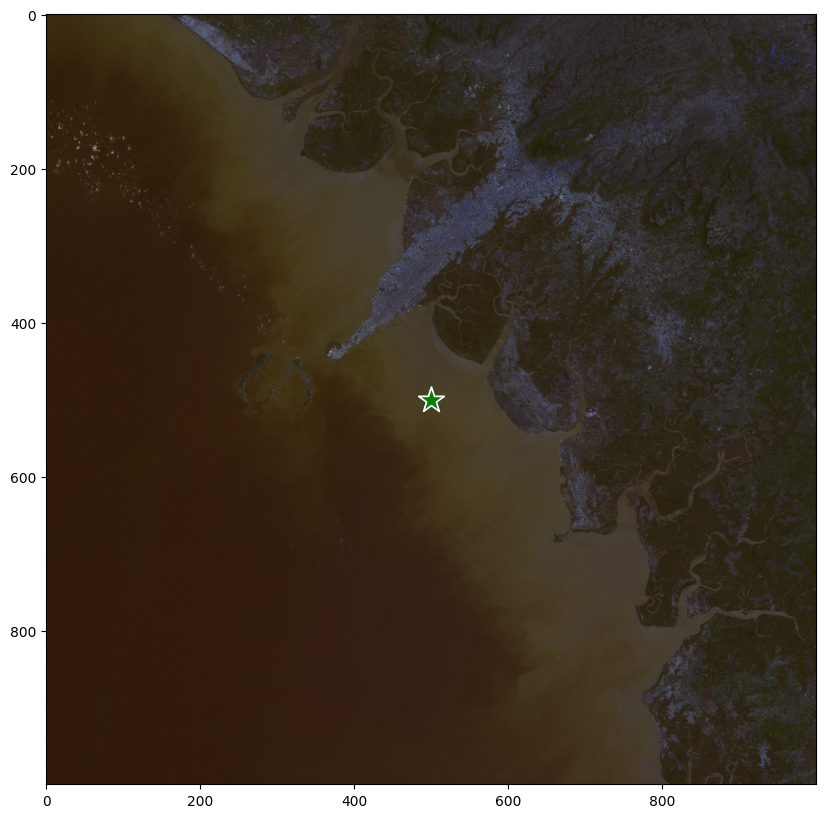

In [125]:
plt.figure(figsize=(10,10))
plt.imshow(rgb_plot)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show() 

In [126]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

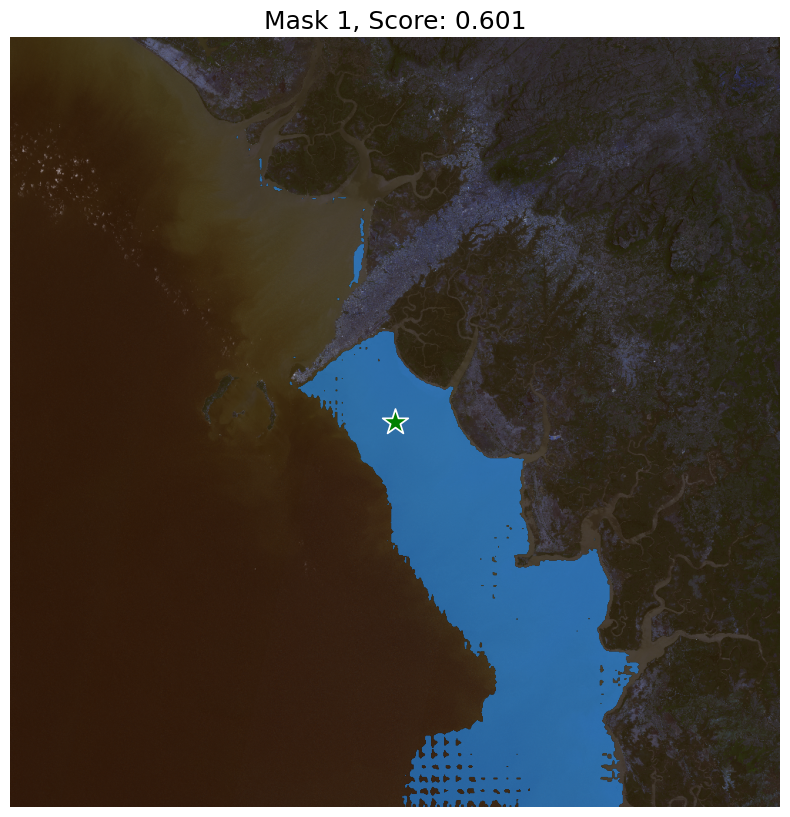

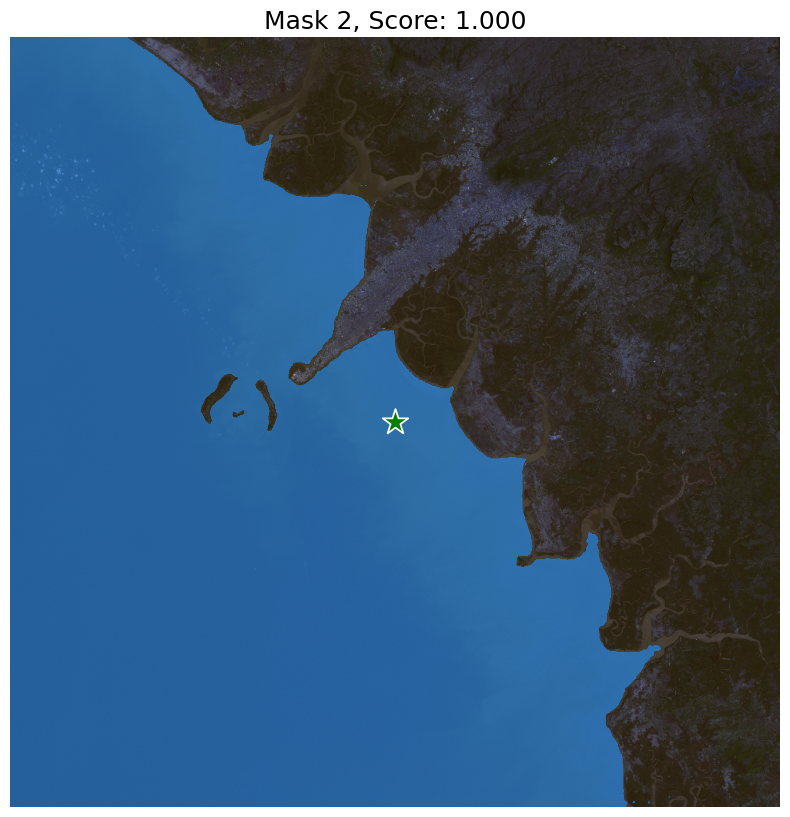

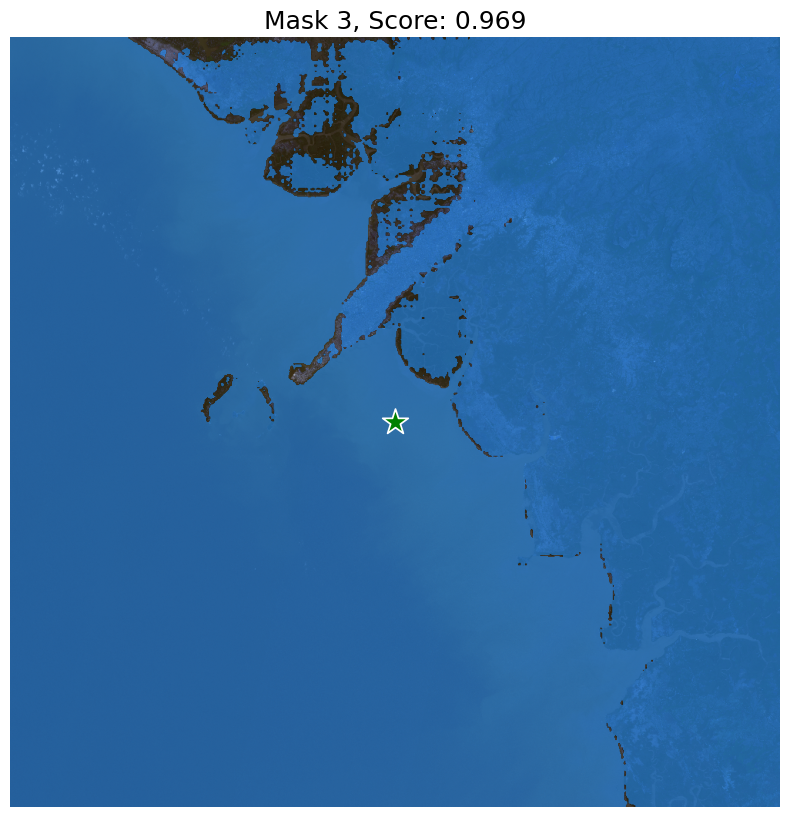

In [127]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(rgb_plot)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  